In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from autogluon.tabular import TabularPredictor




In [4]:
regression_df = pd.read_csv('/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_input/student-por.csv', delimiter=';')

In [5]:
math_data = pd.read_csv('/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_input/student-mat.csv', delimiter=';')
portuguese_data = pd.read_csv('/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_input/student-por.csv', delimiter=';')

print("Math Data:")
print(math_data.head())

print("\nPortuguese Data:")
print(portuguese_data.head())

print("\nMath Data Summary:")
print(math_data.describe())

print("\nPortuguese Data Summary:")
print(portuguese_data.describe())

print("\nMath Data Info:")
print(math_data.info())

print("\nPortuguese Data Info:")
print(portuguese_data.info())


Math Data:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

Portuguese Data:
  school sex  age address famsize Pstatus  Medu  Fedu     M

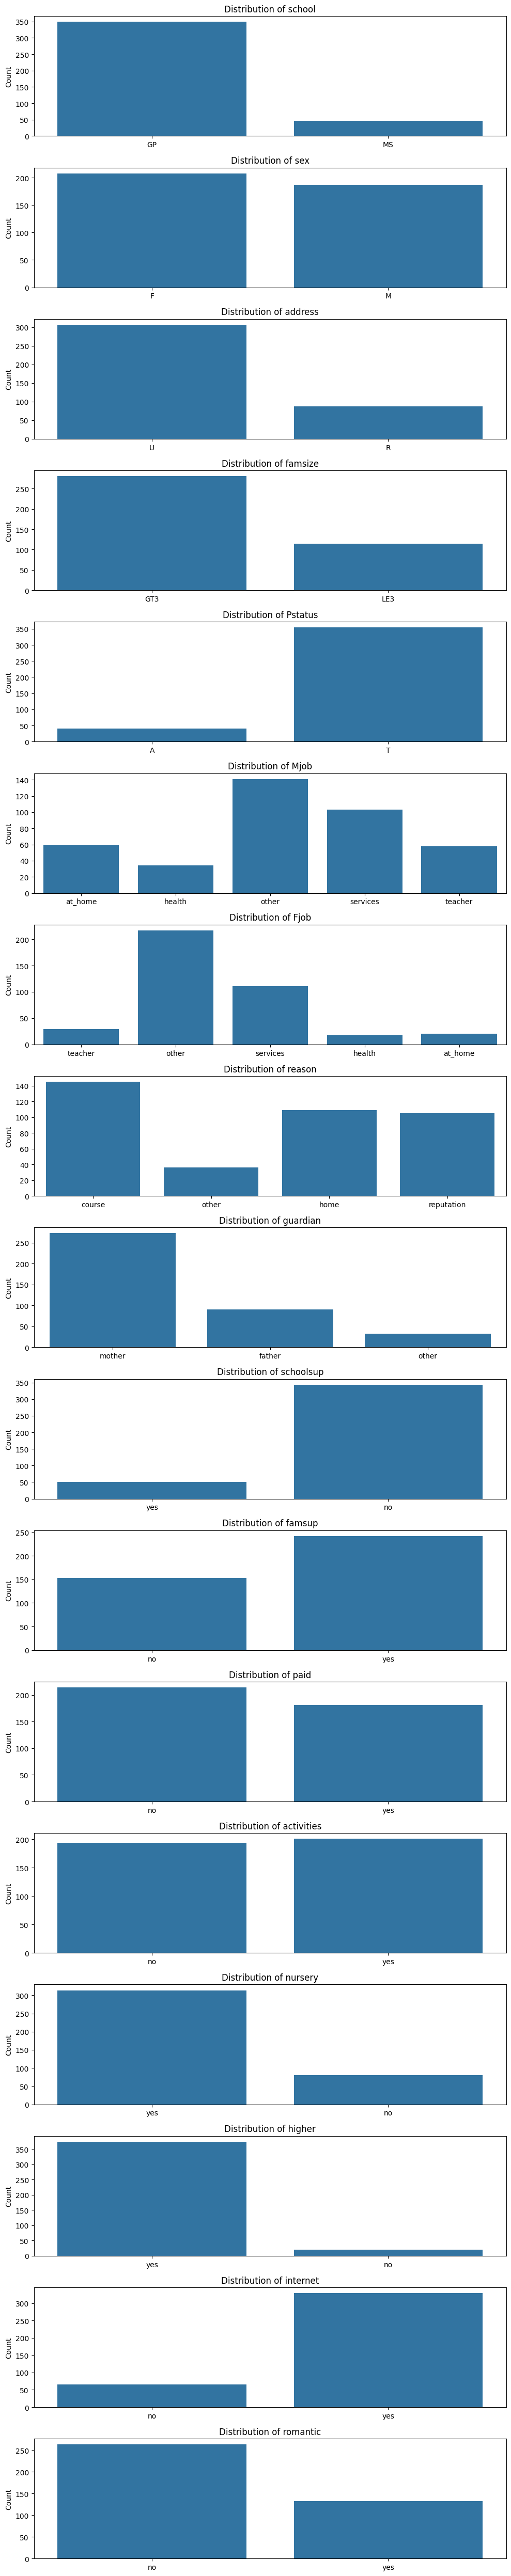

In [6]:

categorical_features = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'
]

fig, axes = plt.subplots(len(categorical_features), 1, figsize=(10, 50))
for i, feature in enumerate(categorical_features):
    sns.countplot(data=math_data, x=feature, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()


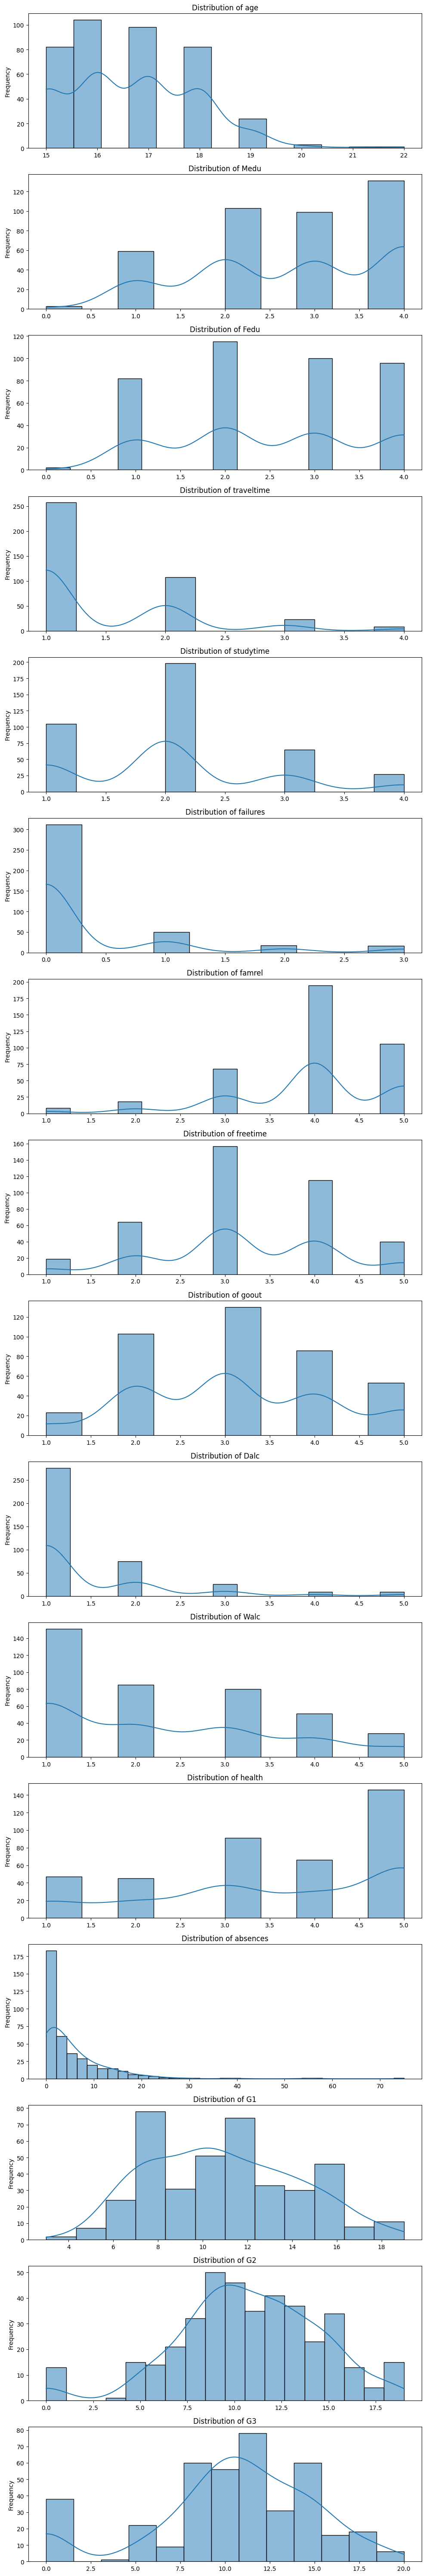

In [7]:
numeric_features = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime',
    'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3'
]

fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 60))
for i, feature in enumerate(numeric_features):
    sns.histplot(data=math_data, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


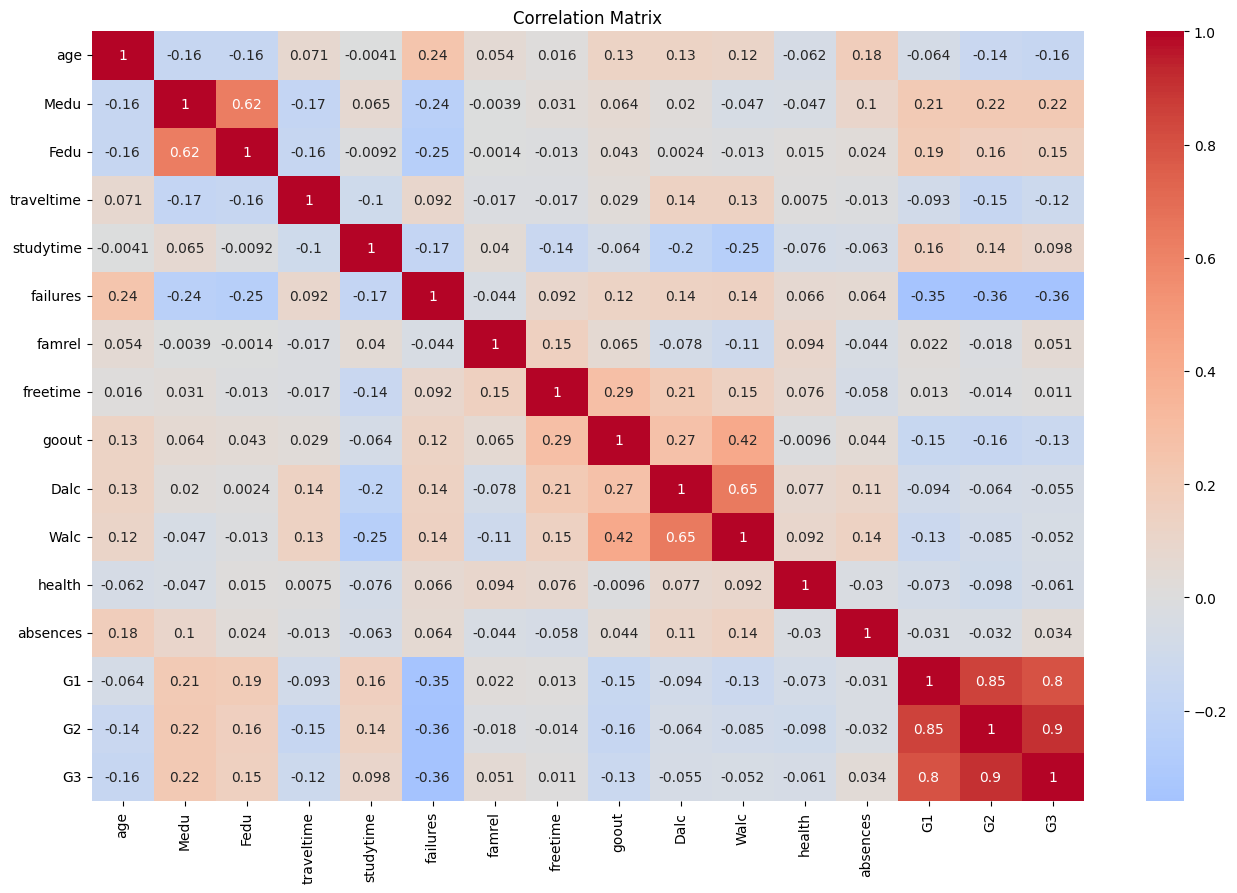

In [8]:
non_numeric_columns = math_data.select_dtypes(exclude=[np.number]).columns

math_data_numeric = math_data.drop(columns=non_numeric_columns)


# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# for col in non_numeric_columns:
#     math_data[col] = label_encoder.fit_transform(math_data[col])

correlation_matrix = math_data_numeric.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


In [9]:
correlation_matrix

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.138325,0.134116,0.007501,-0.012944,-0.093040,-0.153198,-0.117142
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.196019,-0.253785,-0.075616,-0.062700,0.160612,0.135880,0.097820
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.136047,0.141962,0.065827,0.063726,-0.354718,-0.355896,-0.360415
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,-0.077594,-0.113397,0.094056,-0.044354,0.022168,-0.018281,0.051363
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.209001,0.147822,0.075733,-0.058078,0.012613,-0.013777,0.011307
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,0.266994,0.420386,-0.009577,0.044302,-0.149104,-0.162250,-0.132791
Dalc,0.131125,0.019834,0.002386,0.138325,-0.196019,0.136047,-0.077594,0.209001,0.266994,1.000000,0.647544,0.077180,0.111908,-0.094159,-0.064120,-0.054660


## Summary of Correlation Analysis

The correlation matrix reveals several interesting relationships between the variables in the dataset. Here are the key findings:

### Age:
- Positively correlated with **failures** (0.24) and **absences** (0.18), indicating older students tend to have more failures and higher absences.
- Negatively correlated with **G1** (-0.06), **G2** (-0.14), and **G3** (-0.16), suggesting that older students might have lower grades.

### Parent's Education:
- **Mother's education (Medu)** is strongly correlated with **father's education (Fedu)** (0.62), which is expected.
- **Medu** shows positive correlations with **G1** (0.21), **G2** (0.22), and **G3** (0.22), indicating that higher maternal education is associated with better student performance.

### Failures:
- Strong negative correlations with **G1** (-0.35), **G2** (-0.36), and **G3** (-0.36), implying that students with more failures tend to have lower grades.
- Positive correlation with **age** (0.24), suggesting that older students tend to have more failures.

### Study Time:
- Positive correlations with **G1** (0.16) and **G2** (0.14), indicating that more study time is associated with higher grades.
- Negative correlations with **going out (goout)** (-0.06), **daily alcohol consumption (Dalc)** (-0.20), and **weekend alcohol consumption (Walc)** (-0.25), suggesting that students who study more tend to go out and consume alcohol less frequently.

### Alcohol Consumption:
- **Daily alcohol consumption (Dalc)** and **weekend alcohol consumption (Walc)** are highly correlated (0.65), indicating students who drink daily are likely to drink on weekends as well.
- Both **Dalc** and **Walc** have negative correlations with **study time** (-0.20 and -0.25, respectively) and **grades** (e.g., G3: -0.05 and -0.05, respectively), suggesting that higher alcohol consumption is associated with less study time and slightly lower grades.

### Grades:
- The grades **G1**, **G2**, and **G3** are highly correlated with each other (e.g., G1-G2: 0.85, G2-G3: 0.90), which is expected as they represent sequential performance measures.
- Negative correlation with **failures** (G1: -0.35, G2: -0.36, G3: -0.36), indicating that students with more failures tend to have lower grades.

### Absences:
- Slight positive correlation with **age** (0.18) and **daily alcohol consumption (Dalc)** (0.11), indicating older students and those who consume more alcohol tend to have more absences.
- Very weak correlations with **grades** (e.g., G3: 0.03), suggesting absences have a minimal direct impact on grades.

### Free Time and Going Out:
- Positive correlation between **free time** and **going out** (0.29), indicating that students who have more free time tend to go out more often.
- Both have weak correlations with grades, suggesting that these activities have a limited direct effect on academic performance.

## Insights
- **Parental education** plays a significant role in student performance, with higher parental education correlating with better grades.
- **Failures** and **alcohol consumption** negatively impact student performance, suggesting interventions targeting these areas could improve outcomes.
- **Study time** and **parental education** are positive indicators of academic success, highlighting the importance of a supportive and conducive learning environment.


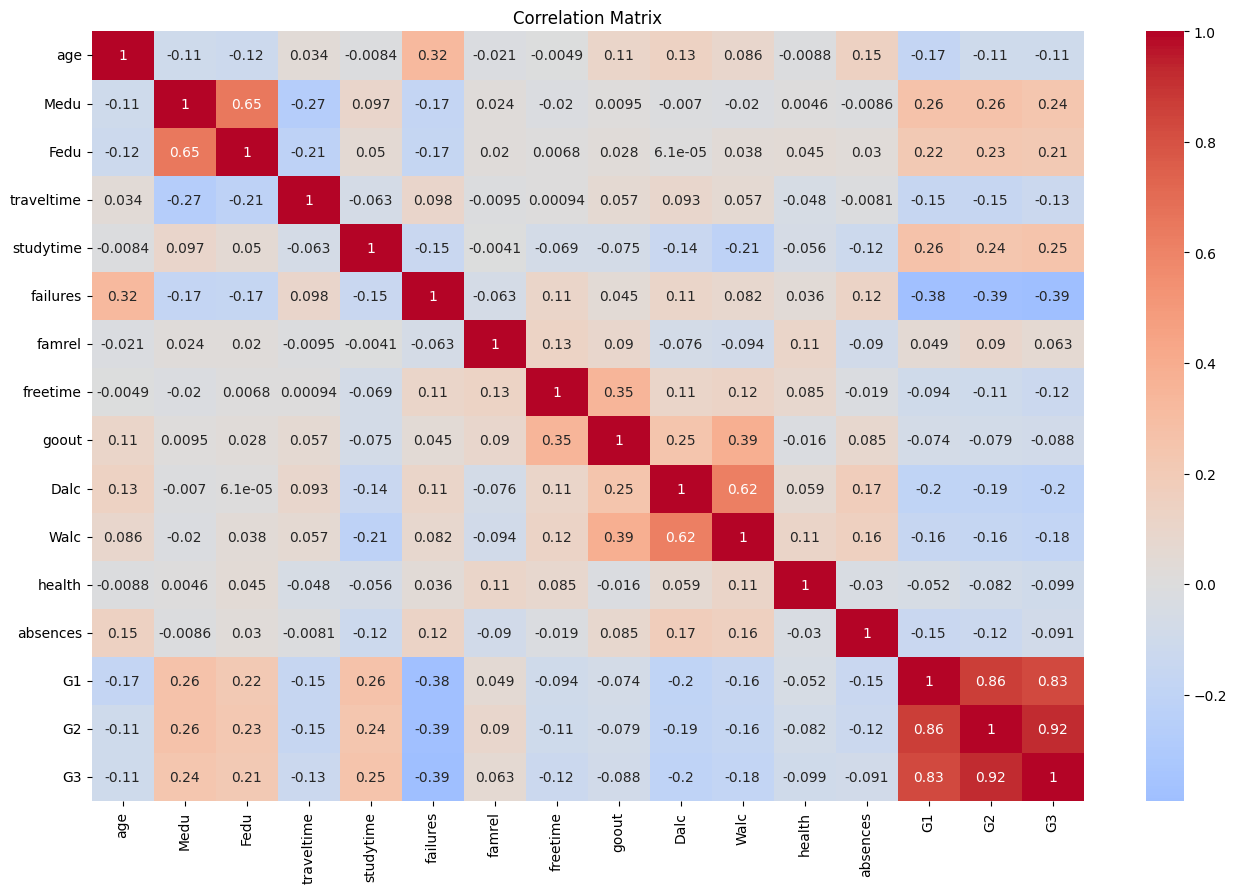

In [10]:
non_numeric_columns_por = portuguese_data.select_dtypes(exclude=[np.number]).columns

port_data_numeric = portuguese_data.drop(columns=non_numeric_columns_por)


# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# for col in non_numeric_columns:
#     math_data[col] = label_encoder.fit_transform(math_data[col])

correlation_matrix_port = port_data_numeric.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix_port, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [11]:
correlation_matrix_port

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
age,1.000000,-0.107832,-0.121050,0.034490,-0.008415,0.319968,-0.020559,-0.004910,0.112805,0.134768,0.086357,-0.008750,0.149998,-0.174322,-0.107119,-0.106505
Medu,-0.107832,1.000000,0.647477,-0.265079,0.097006,-0.172210,0.024421,-0.019686,0.009536,-0.007018,-0.019766,0.004614,-0.008577,0.260472,0.264035,0.240151
Fedu,-0.121050,0.647477,1.000000,-0.208288,0.050400,-0.165915,0.020256,0.006841,0.027690,0.000061,0.038445,0.044910,0.029859,0.217501,0.225139,0.211800
traveltime,0.034490,-0.265079,-0.208288,1.000000,-0.063154,0.097730,-0.009521,0.000937,0.057454,0.092824,0.057007,-0.048261,-0.008149,-0.154120,-0.154489,-0.127173
studytime,-0.008415,0.097006,0.050400,-0.063154,1.000000,-0.147441,-0.004127,-0.068829,-0.075442,-0.137585,-0.214925,-0.056433,-0.118389,0.260875,0.240498,0.249789
failures,0.319968,-0.172210,-0.165915,0.097730,-0.147441,1.000000,-0.062645,0.108995,0.045078,0.105949,0.082266,0.035588,0.122779,-0.384210,-0.385782,-0.393316
famrel,-0.020559,0.024421,0.020256,-0.009521,-0.004127,-0.062645,1.000000,0.129216,0.089707,-0.075767,-0.093511,0.109559,-0.089534,0.048795,0.089588,0.063361
freetime,-0.004910,-0.019686,0.006841,0.000937,-0.068829,0.108995,0.129216,1.000000,0.346352,0.109904,0.120244,0.084526,-0.018716,-0.094497,-0.106678,-0.122705
goout,0.112805,0.009536,0.027690,0.057454,-0.075442,0.045078,0.089707,0.346352,1.000000,0.245126,0.388680,-0.015741,0.085374,-0.074053,-0.079469,-0.087641
Dalc,0.134768,-0.007018,0.000061,0.092824,-0.137585,0.105949,-0.075767,0.109904,0.245126,1.000000,0.616561,0.059067,0.172952,-0.195171,-0.189480,-0.204719


## Summary of Correlation Analysis

The correlation matrix reveals several interesting relationships between the variables in the dataset. Here are the key findings:

### Age:
- Positively correlated with **failures** (0.32) and **absences** (0.15), indicating older students tend to have more failures and higher absences.
- Negatively correlated with **G1** (-0.17), **G2** (-0.11), and **G3** (-0.11), suggesting that older students might have lower grades.

### Parent's Education:
- **Mother's education (Medu)** is strongly correlated with **father's education (Fedu)** (0.65), which is expected.
- **Medu** shows positive correlations with **G1** (0.26), **G2** (0.26), and **G3** (0.24), indicating that higher maternal education is associated with better student performance.

### Failures:
- Strong negative correlations with **G1** (-0.38), **G2** (-0.39), and **G3** (-0.39), implying that students with more failures tend to have lower grades.
- Positive correlation with **age** (0.32), suggesting that older students tend to have more failures.

### Study Time:
- Positive correlations with **G1** (0.26), **G2** (0.24), and **G3** (0.25), indicating that more study time is associated with higher grades.
- Negative correlations with **going out (goout)** (-0.08), **daily alcohol consumption (Dalc)** (-0.14), and **weekend alcohol consumption (Walc)** (-0.21), suggesting that students who study more tend to go out and consume alcohol less frequently.

### Alcohol Consumption:
- **Daily alcohol consumption (Dalc)** and **weekend alcohol consumption (Walc)** are highly correlated (0.62), indicating students who drink daily are likely to drink on weekends as well.
- Both **Dalc** and **Walc** have negative correlations with **study time** (-0.14 and -0.21, respectively) and **grades** (e.g., G3: -0.20 and -0.18, respectively), suggesting that higher alcohol consumption is associated with less study time and slightly lower grades.

### Grades:
- The grades **G1**, **G2**, and **G3** are highly correlated with each other (e.g., G1-G2: 0.86, G2-G3: 0.92), which is expected as they represent sequential performance measures.
- Negative correlation with **failures** (G1: -0.38, G2: -0.39, G3: -0.39), indicating that students with more failures tend to have lower grades.

### Absences:
- Slight positive correlation with **age** (0.15) and **daily alcohol consumption (Dalc)** (0.17), indicating older students and those who consume more alcohol tend to have more absences.
- Very weak correlations with **grades** (e.g., G3: -0.09), suggesting absences have a minimal direct impact on grades.

### Free Time and Going Out:
- Positive correlation between **free time** and **going out** (0.35), indicating that students who have more free time tend to go out more often.
- Both have weak correlations with grades, suggesting that these activities have a limited direct effect on academic performance.

## Insights
- **Parental education** plays a significant role in student performance, with higher parental education correlating with better grades.
- **Failures** and **alcohol consumption** negatively impact student performance, suggesting interventions targeting these areas could improve outcomes.
- **Study time** and **parental education** are positive indicators of academic success, highlighting the importance of a supportive and conducive learning environment.


## Comparison of Correlation Matrices: Math Students vs. Portuguese Students

The two correlation matrices represent different datasets: the first one is for math students, and the second one is for Portuguese students. Here are the key differences and insights derived from comparing the two matrices:

### Key Differences:
1. **Age**:
   - **Math Students**: Age has a positive correlation with failures (0.24) and absences (0.18). It has a negative correlation with grades (G1: -0.06, G2: -0.14, G3: -0.16).
   - **Portuguese Students**: Age shows a stronger positive correlation with failures (0.32) and absences (0.15). It also negatively correlates with grades (G1: -0.17, G2: -0.11, G3: -0.11).

2. **Parent's Education**:
   - **Math Students**: Mother's education (Medu) is positively correlated with grades (G1: 0.21, G2: 0.22, G3: 0.22).
   - **Portuguese Students**: The correlation is stronger with grades (G1: 0.26, G2: 0.26, G3: 0.24).

3. **Failures**:
   - **Math Students**: Failures have a strong negative correlation with grades (G1: -0.35, G2: -0.36, G3: -0.36).
   - **Portuguese Students**: The negative correlation is slightly stronger (G1: -0.38, G2: -0.39, G3: -0.39).

4. **Study Time**:
   - **Math Students**: Study time has positive correlations with grades (G1: 0.16, G2: 0.14, G3: 0.10) and negative correlations with alcohol consumption (Dalc: -0.20, Walc: -0.25).
   - **Portuguese Students**: The positive correlations with grades are stronger (G1: 0.26, G2: 0.24, G3: 0.25), and the negative correlations with alcohol consumption are slightly weaker (Dalc: -0.14, Walc: -0.21).

5. **Alcohol Consumption**:
   - **Math Students**: Daily alcohol consumption (Dalc) and weekend alcohol consumption (Walc) have high correlations (0.65). Both are negatively correlated with study time and grades.
   - **Portuguese Students**: The correlation between Dalc and Walc is slightly lower (0.62). The negative correlations with grades (G3: -0.20 for Dalc, -0.18 for Walc) and study time are consistent but slightly different.

6. **Grades**:
   - **Math Students**: Grades G1, G2, and G3 have high inter-correlations (G1-G2: 0.85, G2-G3: 0.90, G1-G3: 0.80).
   - **Portuguese Students**: These correlations are even stronger (G1-G2: 0.86, G2-G3: 0.92, G1-G3: 0.83).

7. **Absences**:
   - **Math Students**: Absences have weak correlations with grades (G3: 0.03).
   - **Portuguese Students**: Absences have slightly stronger negative correlations with grades (G3: -0.09).

8. **Free Time and Going Out**:
   - **Math Students**: Free time is correlated with going out (0.29). Both have weak correlations with grades.
   - **Portuguese Students**: Free time has a stronger correlation with going out (0.35). The weak correlations with grades remain similar.

### Insights:
- **Consistency in Parental Education**: Both datasets show that higher parental education correlates positively with better grades, although the correlation is stronger for Portuguese students.
- **Stronger Impact of Age on Failures**: For Portuguese students, age has a stronger positive correlation with failures compared to math students.
- **Alcohol Consumption**: Both datasets show that higher alcohol consumption correlates negatively with grades and study time, though the exact correlations vary slightly.
- **Failures**: The correlation between failures and lower grades is strong in both datasets, but slightly stronger for Portuguese students.
- **Study Time**: Consistently, more study time correlates with better grades in both datasets, with a stronger correlation observed for Portuguese students.

These differences and similarities provide valuable insights into how various factors impact student performance across different subjects.


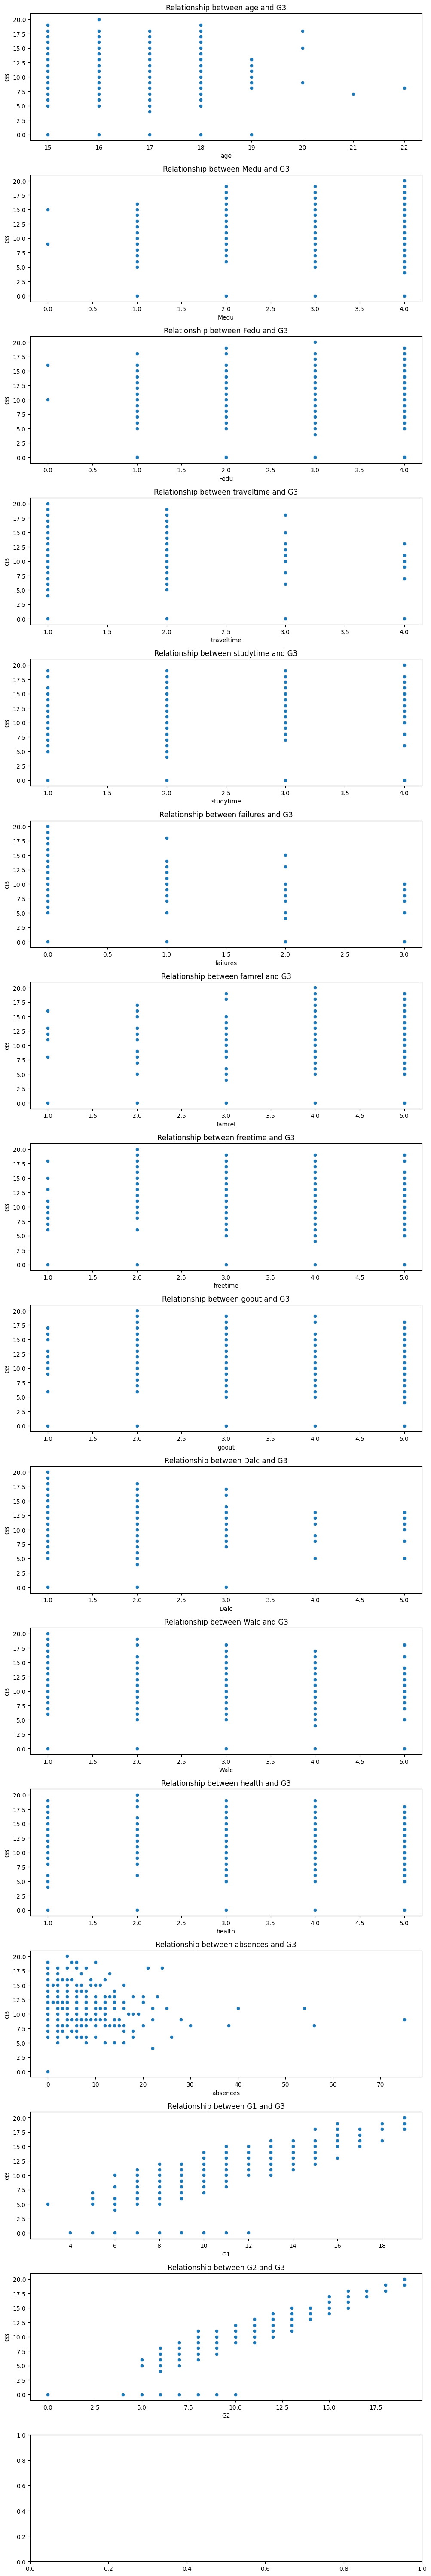

In [12]:
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 60))
for i, feature in enumerate(numeric_features):
    if feature != 'G3':
        sns.scatterplot(data=math_data, x=feature, y='G3', ax=axes[i])
        axes[i].set_title(f'Relationship between {feature} and G3')
plt.tight_layout()
plt.show()


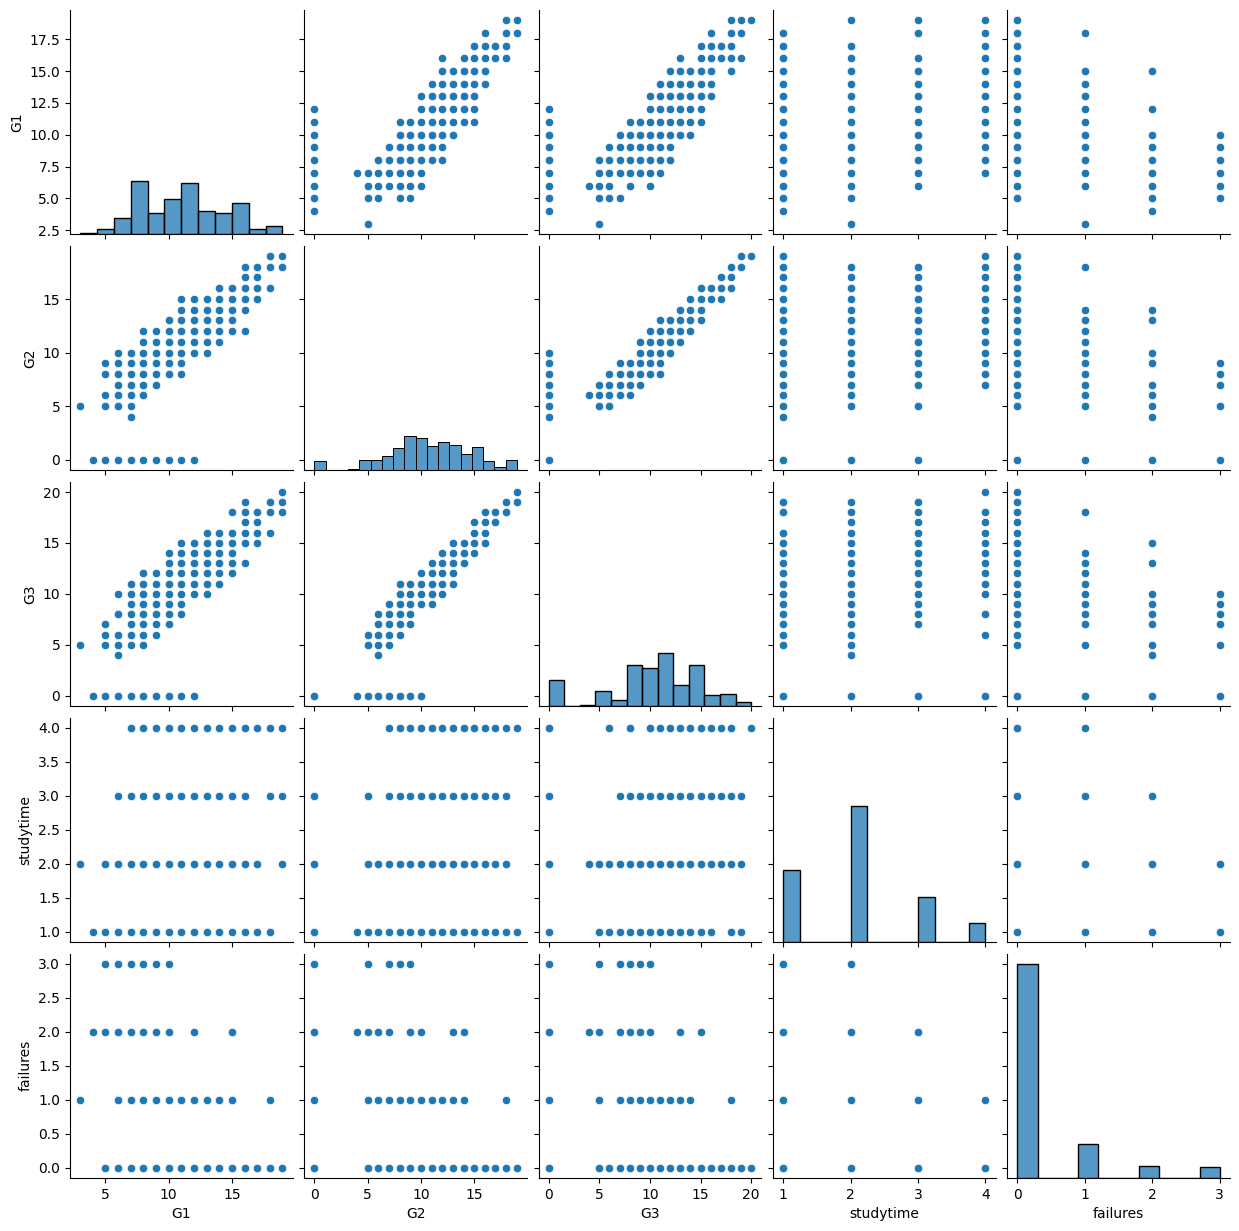

In [13]:
selected_features = ['G1', 'G2', 'G3', 'studytime', 'failures']
sns.pairplot(math_data[selected_features])
plt.show()


# Forecasts

In [14]:
portuguese_data['pass'] = np.where(portuguese_data['G3'] >= 10, 1, 0)

X = portuguese_data.drop(columns=['G3', 'pass'])
y = portuguese_data['pass']

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, lgb_predictions)
print(f'LightGBM Accuracy: {lgb_accuracy:.2f}')

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f'XGBoost Accuracy: {xgb_accuracy:.2f}')

[LightGBM] [Info] Number of positive: 434, number of negative: 85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.836224 -> initscore=1.630393
[LightGBM] [Info] Start training from score 1.630393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [15]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_predictions_prob = lgb_model.predict_proba(X_test)[:, 1]

#plot_confusion_matrix(y_test, lgb_predictions, 'LightGBM Confusion Matrix')
#plot_roc_curve(y_test, lgb_predictions_prob, 'LightGBM ROC Curve')

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_predictions_prob = xgb_model.predict_proba(X_test)[:, 1]

#plot_confusion_matrix(y_test, xgb_predictions, 'XGBoost Confusion Matrix')
#plot_roc_curve(y_test, xgb_predictions_prob, 'XGBoost ROC Curve')

[LightGBM] [Info] Number of positive: 434, number of negative: 85
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.836224 -> initscore=1.630393
[LightGBM] [Info] Start training from score 1.630393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

## Model Performance and Visualization

### XGBoost Model
1. **ROC Curve**:
   - AUC: 0.95, indicating strong ability to distinguish between pass and fail.
   - High true positive rate and low false positive rate.

   ![XGBoost ROC Curve](/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_output/xgboost_roc.png)

2. **Confusion Matrix**:
   - True Positives: 110, True Negatives: 8
   - False Positives: 7, False Negatives: 5
   - Good performance with high precision and recall for predicting pass outcomes.

   ![XGBoost Confusion Matrix](/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_output/xgboost_confusion_matrix.png)

### LightGBM Model
1. **ROC Curve**:
   - AUC: 0.96, slightly better than XGBoost.
   - High true positive rate and low false positive rate.

   ![LightGBM ROC Curve](/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_output/lightgbm_roc.png)

2. **Confusion Matrix**:
   - True Positives: 108, True Negatives: 10
   - False Positives: 5, False Negatives: 7
   - Good performance with high precision and recall for predicting pass outcomes.

   ![LightGBM Confusion Matrix](/Users/patrickpetter/Desktop/pacemaker_dev/clients/shannon_assignment/data_output/lightgbm_confusion_matrix.png)

### Summary
- Both models perform well in predicting pass/fail, with high AUC scores (XGBoost: 0.95, LightGBM: 0.96).
- Confusion matrices show high true positive rates and low false positive/negative rates.
- LightGBM slightly outperforms XGBoost in terms of AUC.

### Conclusion
- Both XGBoost and LightGBM are effective for predicting student performance. The choice may depend on other factors such as training time and resource usage.



## autogluon

In [16]:
portuguese_data['pass'] = np.where(portuguese_data['G3'] >= 10, 1, 0)

X = portuguese_data.drop(columns=['G3', 'pass'])
y = portuguese_data['pass']

X_encoded = pd.get_dummies(X, drop_first=True)
data_encoded = pd.concat([X_encoded, y], axis=1)

train_data, test_data = train_test_split(data_encoded, test_size=0.2, random_state=42)

predictor = TabularPredictor(label='pass', verbosit = 1).fit(train_data,presets='best_quality')
#predictor = TabularPredictor(label='pass', verbosity=4).fit(train_data, time_limit=600, num_bag_folds=2)


y_pred = predictor.predict(test_data)
y_pred_prob = predictor.predict_proba(test_data).iloc[:, 1]

accuracy = accuracy_score(test_data['pass'], y_pred)
print(f'AutoGluon Accuracy: {accuracy:.2f}')

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_pred_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

plot_confusion_matrix(test_data['pass'], y_pred, 'AutoGluon Confusion Matrix')
plot_roc_curve(test_data['pass'], y_pred_prob, 'AutoGluon ROC Curve')


No path specified. Models will be saved in: "AutogluonModels/ag-20240802_091747"
Verbosity: 4 (Maximum Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.6.0: Fri Jul  5 17:55:37 PDT 2024; root:xnu-10063.141.1~2/RELEASE_ARM64_T6030
CPU Count:          12
GPU Count:          0
Memory Avail:       13.61 GB / 36.00 GB (37.8%)
Disk Space Avail:   80.24 GB / 460.43 GB (17.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fas